This notebook provide example of training classification model (CV).

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

import logging
import matplotlib.pyplot as plt

from PIL import Image

from classifier.trainer_classifier import AnimalImageClassifier
from classifier.inference_classifier import predict_image

In [4]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    force=True)
logger = logging.getLogger(__name__)

2025-07-04 11:14:56,222 - INFO - Using device: cuda
2025-07-04 11:14:56,315 - INFO - Loading datasets from data/images/train and data/images/val
2025-07-04 11:15:14,943 - INFO - Created Training DataLoader with 12997 samples.
2025-07-04 11:15:14,943 - INFO - Created Validation DataLoader with 2764 samples.
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s] 
2025-07-04 11:15:15,540 - INFO - Model initialized with 10 classes.
2025-07-04 11:15:15,542 - INFO - Epoch 1/10


Starting training...


Evaluating: 100%|██████████| 87/87 [10:06<00:00,  6.97s/it]
2025-07-04 12:08:09,671 - INFO - Training Loss: 0.4053 | Val Loss: 0.1506 | F1 Score: 0.9512
2025-07-04 12:08:10,865 - INFO - Best model saved with F1 Score: 0.9512
2025-07-04 12:08:10,866 - INFO - Epoch 2/10
Evaluating: 100%|██████████| 87/87 [00:14<00:00,  5.89it/s]
2025-07-04 12:09:57,404 - INFO - Training Loss: 0.1924 | Val Loss: 0.1235 | F1 Score: 0.9578
2025-07-04 12:09:57,501 - INFO - Best model saved with F1 Score: 0.9578
2025-07-04 12:09:57,502 - INFO - Epoch 3/10
Evaluating: 100%|██████████| 87/87 [00:14<00:00,  6.04it/s]
2025-07-04 12:11:42,664 - INFO - Training Loss: 0.1439 | Val Loss: 0.1136 | F1 Score: 0.9649
2025-07-04 12:11:42,753 - INFO - Best model saved with F1 Score: 0.9649
2025-07-04 12:11:42,754 - INFO - Epoch 4/10
Evaluating: 100%|██████████| 87/87 [00:14<00:00,  6.16it/s]
2025-07-04 12:13:25,772 - INFO - Training Loss: 0.0953 | Val Loss: 0.1314 | F1 Score: 0.9612
2025-07-04 12:13:25,772 - INFO - Epoch 5

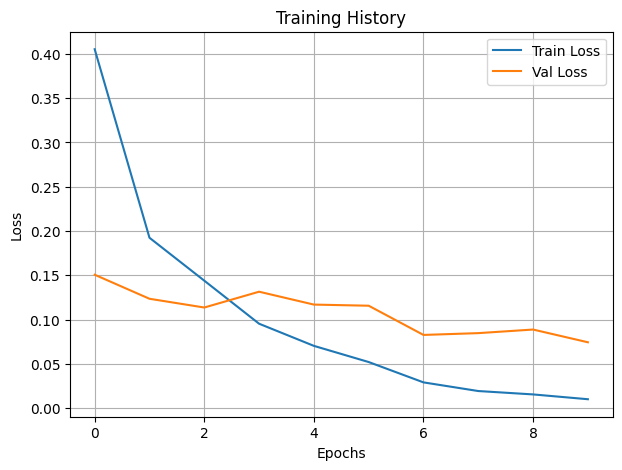

2025-07-04 12:23:39,584 - INFO - Training completed!


In [ ]:
data_dir = '../data/images'
model_path = '../models/image_classifier'

classifier = AnimalImageClassifier(
    data_dir=data_dir,
    batch_size=32,
    learning_rate=1e-3,
    model_path=model_path
)
print("Starting training...")
trained_model = classifier.train(num_epochs=10)

2025-07-04 12:35:05,366 - INFO - Test loader initialized with 12997 samples.
Evaluating: 100%|██████████| 407/407 [01:13<00:00,  5.54it/s]


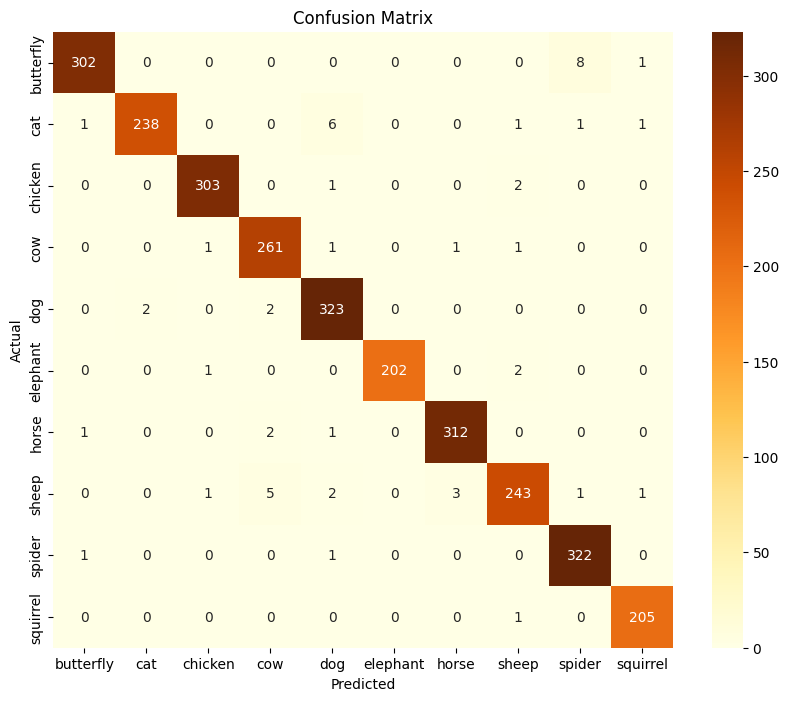

In [ ]:
classifier.setup_test_loader()
classifier.evaluate_test()
classifier.plot_confusion_matrix(classifier.test_loader)

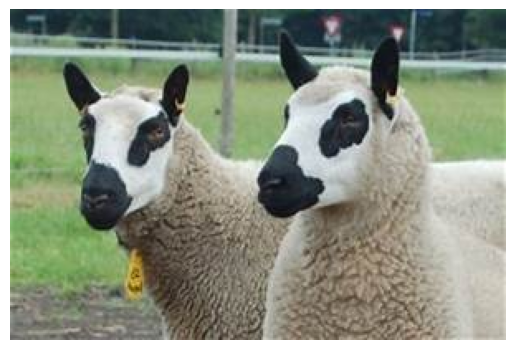

In [ ]:
test_img = '../data/images/test/sheep/OIP-jW9uZm9cox2kzddQLCN9NAHaE8.jpeg'
img = Image.open(test_img)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
pred_class, conf = classifier.predict(test_img)
print(f"Predicted: {pred_class} ({conf:.4f})")

Predicted: sheep (1.0000)


2025-07-12 20:03:44,079 - INFO - Model loaded from ../models/image_classifier


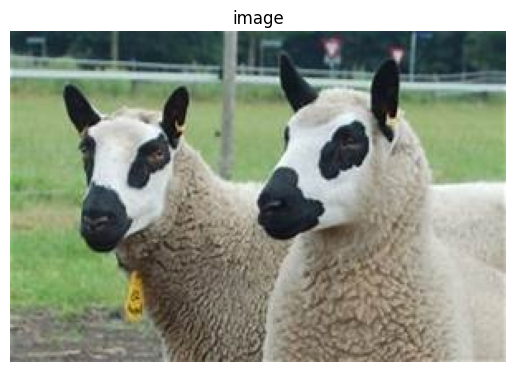

Predicted class: sheep, Confidence: 1.00


In [ ]:
model_path = '../models/image_classifier'
img_class, confidence = predict_image(test_img, model_path, show_image=True)
print(f"Predicted class: {img_class}, Confidence: {confidence:.2f}")